In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format='svg'

import numpy as np
np.set_printoptions(precision=6, suppress=True)
np.set_printoptions(threshold=np.inf)

import shl_scripts.shl_tools
from shl_scripts.shl_experiments import SHL

import DNN.mnist_loader as data_loader
import DNN.network as network
from shl_scripts.shl_encode import sparse_encode

In [2]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
training_data,validation_data,test_data=data_loader.load_data()
training_image = training_data[0]
training_supervision = training_data[1]
test_image = test_data[0]
test_supervision = test_data[1]

In [4]:
tag ='2017-05-18 MNIST_MEUL '
DEBUG_DOWNSCALE, verbose = 1, 10
patch_size = (28,28)
n_dictionary = 30**2
n_iter = 2**14
eta = 0.01
eta_homeo = 0.01
verbose = 0
list_figures=['show_dico']
n_hidden = 100

 ----- learning for the dico of size : 144 -----
Epoch 0: 1610 / 10000
Epoch 1: 1690 / 10000
Epoch 2: 2107 / 10000
Epoch 3: 2112 / 10000
Epoch 4: 2110 / 10000
Epoch 5: 2345 / 10000
Epoch 6: 2162 / 10000
Epoch 7: 2896 / 10000
Epoch 8: 2676 / 10000
Epoch 9: 2877 / 10000
Epoch 10: 2647 / 10000
Epoch 11: 2297 / 10000
Epoch 12: 2184 / 10000
Epoch 13: 2314 / 10000
Epoch 14: 2600 / 10000
Epoch 15: 2772 / 10000
Epoch 16: 2169 / 10000
Epoch 17: 2290 / 10000
Epoch 18: 2167 / 10000
Epoch 19: 2296 / 10000
Epoch 20: 2117 / 10000
Epoch 21: 2115 / 10000
Epoch 22: 2236 / 10000
Epoch 23: 2572 / 10000
Epoch 24: 2828 / 10000
Epoch 25: 2938 / 10000
Epoch 26: 2902 / 10000
Epoch 27: 3771 / 10000
Epoch 28: 2978 / 10000
Epoch 29: 3447 / 10000
 ----- learning for the dico of size : 225 -----
Epoch 0: 2212 / 10000
Epoch 1: 2109 / 10000
Epoch 2: 2115 / 10000
Epoch 3: 2776 / 10000
Epoch 4: 2084 / 10000
Epoch 5: 2335 / 10000
Epoch 6: 2104 / 10000
Epoch 7: 2165 / 10000
Epoch 8: 2103 / 10000
Epoch 9: 2334 / 10000
Ep

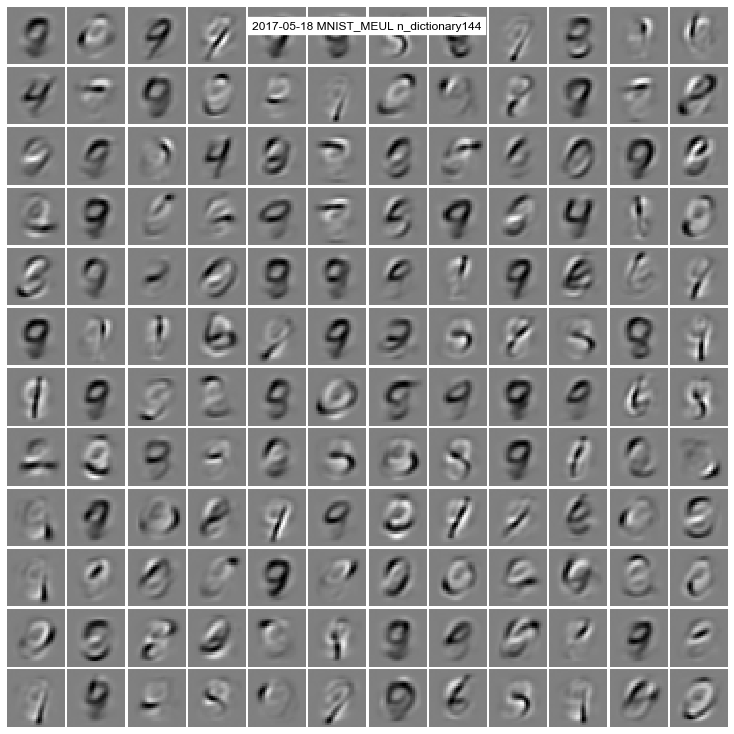

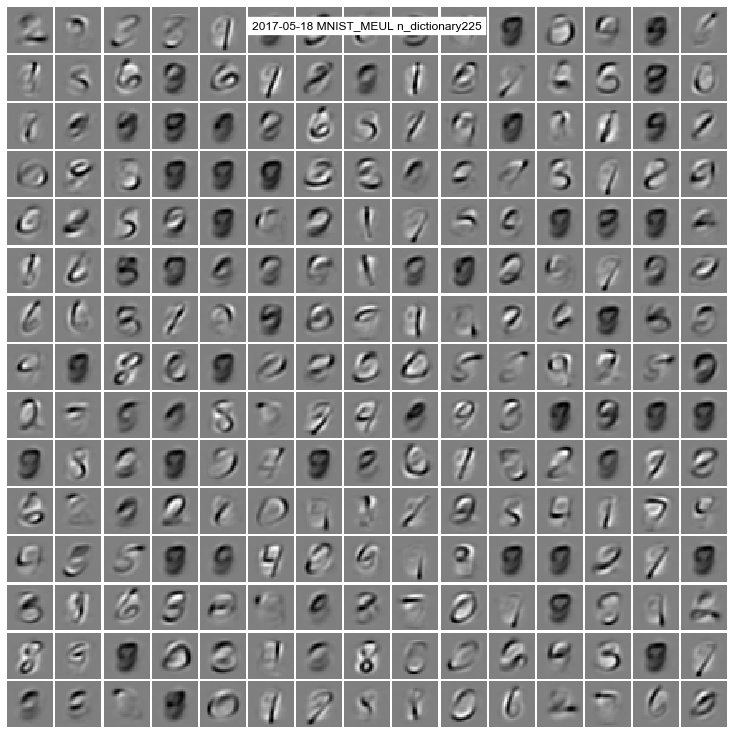

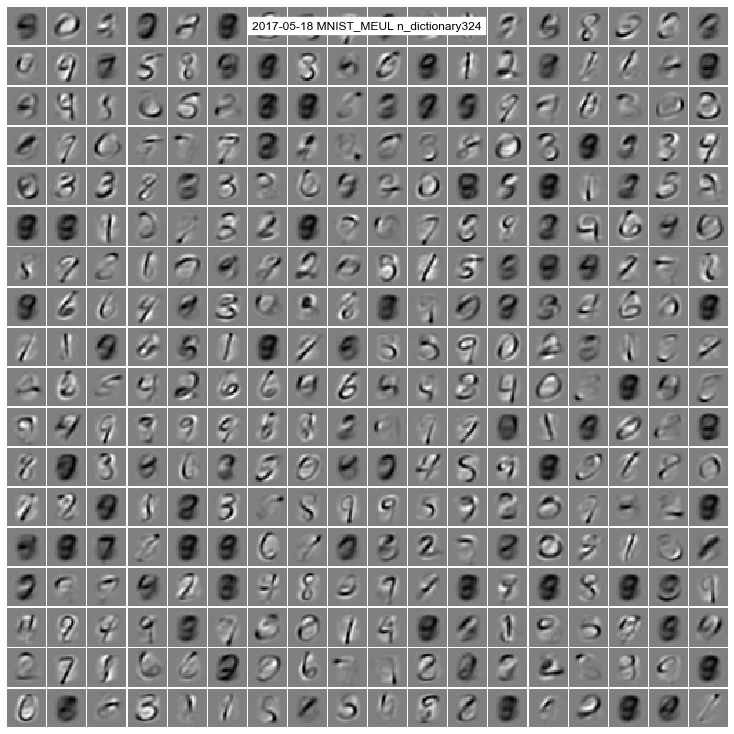

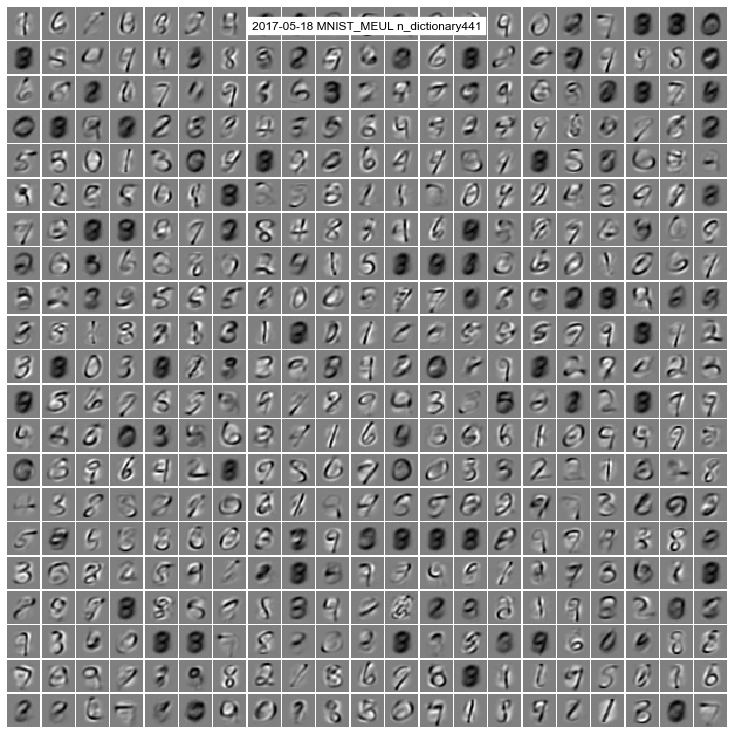

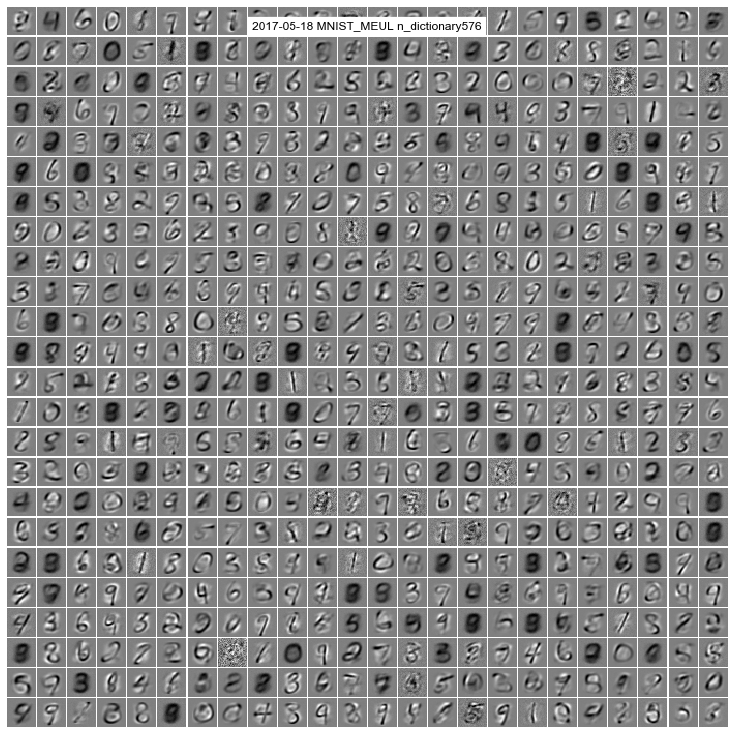

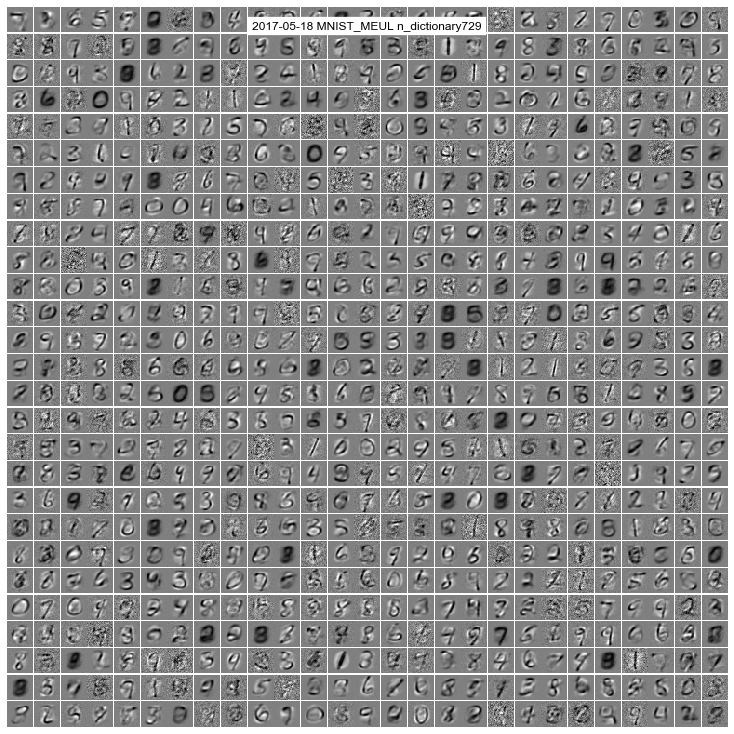

In [6]:
for n_dictionary in np.arange(12, 30, 3)**2:
    
    shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
                eta=eta, eta_homeo=eta_homeo, verbose=verbose,
                n_iter=n_iter, patch_size=patch_size,
                n_dictionary=n_dictionary)
    dico = shl.learn_dico(data=training_image, matname=tag + 'n_dictionary' + str(n_dictionary),list_figures=list_figures)
    
    ## formating the date to fit theano standard
    training_vector = (dico.dictionary @ training_image.T).T
    test_vector = (dico.dictionary @ test_image.T).T
    wrapped_training_data = (training_vector, training_supervision)
    wrapped_test_data = (test_vector, test_supervision)
    
    wrapped_inputs = [np.reshape(x, (n_dictionary, 1)) for x in wrapped_training_data[0]]
    wrapped_results = [vectorized_result(y) for y in wrapped_training_data[1]]
    wrapped_training_data = zip(wrapped_inputs, wrapped_results)
    wrapped_test_inputs = [np.reshape(x, (n_dictionary, 1)) for x in wrapped_test_data[0]]
    wrapped_test_data_final = zip(wrapped_test_inputs, wrapped_test_data[1])
    
    print(" ----- learning for the dico of size : {0} -----".format(n_dictionary))
    ## running the network
    net=network.Network([n_dictionary, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=10,
       eta=3.0,
       test_data=wrapped_test_data_final)


In [ ]:
n_dictionary=256
for l0_sparseness in np.arange(5, 40, 5):
    
    shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
                eta=eta, eta_homeo=eta_homeo, verbose=verbose,
                n_iter=n_iter, patch_size=patch_size, l0_sparseness=l0_sparseness,
                n_dictionary=n_dictionary)
    dico = shl.learn_dico(data=training_image, matname=tag + 'l0_sparseness=' + str(l0_sparseness), list_figures=list_figures)    
    
    ## formating the date to fit theano standard
    training_vector = dico.dictionary @ training_image 
    test_vector = dico.dictionary @ test_image 
    wrapped_training_data = (training_vector, training_supervision)
    wrapped_test_data = (test_vector, test_supervision)
    
    wrapped_inputs = [np.reshape(x, (shl.n_dictionary, 1)) for x in wrapped_training_data[0]]
    wrapped_results = [vectorized_result(y) for y in wrapped_training_data[1]]
    wrapped_training_data = zip(wrapped_inputs, wrapped_results)
    wrapped_test_inputs = [np.reshape(x, (shl.n_dictionary, 1)) for x in wrapped_test_data[0]]
    wrapped_test_data_final = zip(wrapped_test_inputs, wrapped_test_data[1])
    
    print(" ----- learning for the dico of spareseness: {0} -----".format(l0_sparseness))
    ## running the network
    net=network.Network([shl.n_dictionary, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=10,
       eta=3.0,
       test_data=wrapped_test_data_final)

In [ ]:
    print(net.evaluate(wrapped_test_data_final))
